## Content based Collaborative Filtering

## Importing Libaries & loading data & preprocessing

In [1]:
# importing libraries
import numpy as np
import pandas as pd

from sklearn.metrics import jaccard_score
from sklearn.feature_extraction import text
from scipy.spatial.distance import pdist, squareform
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer
import ast

# for each book recommended we find the bayesian score -> sort based on score
# 

In [ ]:
S

In [3]:
# load book info
book_genre = pd.read_csv('data/books_data.csv')
# process books
book_genre = preprocess_books_df(book_genre)

# preprocessing for books_genres
book_genre = book_genre[['title', 'categories','description']]
book_genre.dropna(subset=["categories","description"], inplace=True)
book_genre['combined_text']=book_genre.apply(boost_genres,axis=1)
 
# load reviews
review_df = pd.read_csv('data/Books_rating.csv')
review_df = preprocess_reviews_df(review_df)

C:\Users\insiy\AppData\Local\Temp\ipykernel_21828\1819215468.py:78: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  lambda x: datetime.utcfromtimestamp(x).year
C:\Users\insiy\AppData\Local\Temp\ipykernel_21828\1819215468.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df["helpfulness"] = reviews_df["helpfulness"].replace("0/0", 0)
C:\Users\insiy\AppData\Local\Temp\ipykernel_21828\1819215468.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [4]:
df= book_genre.copy()

custom_stop_words = list(ENGLISH_STOP_WORDS.union({'&','book', 'novel', 'story','[',']'}))

vectorizer = TfidfVectorizer(
    min_df= 50, # words must appear in at least 50 books
    max_df=0.70, # ignore words appearing in more than 70% of books
    stop_words=custom_stop_words,  
    token_pattern=r"(?u)\b[a-zA-Z]+\b", # only words with letters
    max_features= 300 # limit to top 300 terms
)  

# Fit and transform the combined text
tfidf_matrix = vectorizer.fit_transform(df['combined_text'])

## Based on Bayesian we predict the top books to display of the genres


In [5]:
def bayesian_scoring(reviews_df,C,m):
    """
    Calculate Bayesian scoring for books based on reviews.

    Args:
        reviews_df (pd.DataFrame): DataFrame with at least ['title', 'score'] columns.
        C (float): Confidence factor (e.g., average number of ratings).
        m (float): Global mean rating.

    Returns:
        pd.DataFrame: Books ranked by Bayesian score (highest first).
    """

    #step 1: create array with title, average rating of each book, and # of ratings
    books_avg_ratings = reviews_df.groupby(['title']).agg(
        avg_rating=('score', 'mean'),  
        num_ratings=('score', 'count') 
    ).reset_index()

    #step 2: bayesian score
    books_avg_ratings['bayesian_score'] = (
        (C * m + books_avg_ratings['num_ratings'] * books_avg_ratings['avg_rating']) /
        (C + books_avg_ratings['num_ratings'])
    )
    #step 3: rank the books based on their bayesian score
    books_ranked = books_avg_ratings.sort_values(
        by=['bayesian_score'], 
        ascending=False)
    
    return books_ranked

In [6]:
cold_start_books = bayesian_scoring(review_df,C= 20,m=review_df['score'].mean())
cold_start_books = cold_start_books[['title','bayesian_score']]
cold_start_books

,title,bayesian_score
190741,With the Old Breed: At Peleliu and Okinawa,4.891725
85629,Lilla Belle: The First Stages,4.874057
149842,"The Ferret Calendar 2005, Ferret Music",4.860288
169344,The Valley of Vision: a Collection of Puritan ...,4.851955
20423,Betty Crocker's cooky book,4.847018
...,...,...
118444,Red Rabbit,2.300248
80942,Killing Time,2.289472
39314,Day of Reckoning: The Massacre at Columbine Hi...,2.014691
113571,Predator (Kay Scarpetta Mysteries),1.936874


In [7]:
print(tfidf_matrix.tocoo())

  (0, 25)	0.565928188945861
  (0, 15)	0.5850089456223833
  (0, 258)	0.12206796932715272
  (0, 97)	0.1329721372080781
  (0, 159)	0.12170699173437718
  (0, 140)	0.1225148017321587
  (0, 229)	0.10248280256687962
  (0, 31)	0.13346007092827444
  (0, 196)	0.14026983589926809
  (0, 11)	0.11551771005801785
  (0, 195)	0.12475949775149282
  (0, 198)	0.12367169066730711
  (0, 5)	0.11623273122410756
  (0, 150)	0.32191671057098314
  (0, 144)	0.11272254162738285
  (0, 179)	0.07142321987408386
  (0, 289)	0.13467595579840644
  (0, 254)	0.1315858335604724
  (0, 128)	0.11176206850938512
  (1, 223)	0.8735823136672103
  (1, 130)	0.17032403253705922
  (1, 274)	0.19811729484924695
  (1, 240)	0.21920109167205093
  (1, 40)	0.2422826487302994
  (1, 188)	0.16911645980815807
  :	:
  (137885, 299)	0.15493265801886827
  (137885, 37)	0.19167023313344558
  (137885, 230)	0.17912498853749767
  (137885, 265)	0.12890010662681162
  (137885, 183)	0.15827922351195145
  (137885, 296)	0.1618663790023989
  (137886, 100)	0.558

In [8]:
# top 300 unique words in the dictionary
vectorizer.get_feature_names_out()

array(['account', 'activities', 'adult', 'advice', 'age', 'america',
       'american', 'analysis', 'ancient', 'approach', 'architecture',
       'art', 'arts', 'author', 'authors', 'autobiography', 'available',
       'award', 'based', 'basic', 'beautiful', 'best', 'bestselling',
       'better', 'bible', 'biography', 'black', 'body', 'books',
       'business', 'care', 'career', 'case', 'century', 'change',
       'chapter', 'chapters', 'child', 'children', 'christian', 'church',
       'city', 'classic', 'clear', 'collection', 'color', 'come',
       'comics', 'common', 'complete', 'comprehensive', 'computers',
       'concepts', 'contains', 'contemporary', 'cooking', 'country',
       'course', 'covers', 'crafts', 'create', 'crime', 'critical',
       'criticism', 'cultural', 'culture', 'current', 'd', 'day', 'death',
       'describes', 'design', 'designed', 'detailed', 'development',
       'different', 'disciplines', 'discover', 'does', 'drama', 'early',
       'easy', 'economic

In [ ]:
# find nearest neighbors (similar items) in a dataset instead of computing all pairwise distances
"""
n_neighbors=1000 → When you ask for neighbors, it will return the 1000 most similar books.
metric='cosine' → Measures similarity based on the angle between TF-IDF vectors (ignores magnitude).
algorithm='brute' → Computes distances by checking every book in the dataset; works well with sparse TF-IDF matrices.
"""
from sklearn.neighbors import NearestNeighbors

# Use cosine distance on the sparse TF-IDF matrix
# Cosine distance = 1 − cosine similarity
nn = NearestNeighbors(n_neighbors=10000, 
                      metric='cosine', 
                      algorithm='brute')
nn.fit(tfidf_matrix)


NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=10000)

### Based on we have a book and we want to find books similar to it


In [10]:
# stores the cosine distance -> distance
# stores the indicies of closest books -> indices

# this is if we want to recommend based on similar book content
distances, indices = nn.kneighbors(tfidf_matrix[3])
recommended_books = df.iloc[indices[0][:]]
recommended_books.head(10)
print(f'Recommedation for book 0\n{recommended_books.head(3)}')


Recommedation for book 0
                                                    title    categories  \
5       The Church of Christ: A Biblical Ecclesiology ...  ['Religion']   
54474   Renewing the Vision: Reformed Faith for the 21...  ['Religion']   
198778  The Church in Antioch in the First Century CE:...  ['Religion']   

                                              description  \
5       In The Church of Christ: A Biblical Ecclesiolo...   
54474   The five themes around which Campbell organize...   
198778  The book explores the problems faced by the ch...   

                                            combined_text  
5        ['religion'] ['religion'] ['religion'] ['reli...  
54474    ['religion'] ['religion'] ['religion'] ['reli...  
198778   ['religion'] ['religion'] ['religion'] ['reli...  


### Solving cold start problem

List of Genres user can select from

In [11]:
# user enters from a given list of genres
genres = [
    "Fiction","History","Religion","Biography & Autobiography",
    "Business & Economics","Computers","Social Science","Juvenile Nonfiction",
    "Science","Education","Cooking","Sports & Recreation","Family & Relationships",
    "Literary Criticism","Music","Medical",
    "Body, Mind & Spirit","Health & Fitness","Language Arts & Disciplines"
    "Love"
]

In [12]:
df.categories.value_counts().head(20)

categories
['Fiction']                        22393
['History']                         8845
['Religion']                        8758
['Juvenile Fiction']                6572
['Biography & Autobiography']       6047
['Business & Economics']            5285
['Computers']                       4119
['Social Science']                  3612
['Juvenile Nonfiction']             3312
['Science']                         2422
['Education']                       2276
['Cooking']                         2220
['Sports & Recreation']             2121
['Family & Relationships']          2066
['Literary Criticism']              2021
['Music']                           1944
['Medical']                         1936
['Body, Mind & Spirit']             1913
['Health & Fitness']                1911
['Language Arts & Disciplines']     1890
Name: count, dtype: int64

In [13]:
#Recommend books for a new user by selected genres

def recommend_for_new_user(selected_genres, vectorizer=vectorizer, nn=nn, df=df, top_n=10000, final_k = 10,boost=5):
    # Combine and boost genres
    user_text = (' '.join(selected_genres).lower() + ' ') * boost
    
    # Transform to TF-IDF
    user_vector = vectorizer.transform([user_text])
    
    # Find nearest neighbors
    distances, indices = nn.kneighbors(user_vector, n_neighbors=top_n)
    rec = df.iloc[indices[0]][['title', 'categories']]
    rec_df = rec.merge(cold_start_books, on='title',how='left')
    rec_df = rec_df.sort_values(by='bayesian_score',ascending=False)

    return rec_df.head(final_k)


In [26]:
d = np.sort(distances)
print(d.tolist())


[[0.0, 0.08819333916198424, 0.09228642075676752, 0.10198486477987279, 0.10494883118750398, 0.10676401251407308, 0.11061759512546032, 0.11122585277388053, 0.11788372119581603, 0.11944326711185127, 0.12499468409985715, 0.12506561242344116, 0.12931719822912724, 0.1309213386554483, 0.1328492706641019, 0.13288927571320952, 0.1334296337375548, 0.13370249741534046, 0.1338549320563679, 0.13615003583206908, 0.1377541917300632, 0.13827339707615538, 0.13869726585056097, 0.13909334860336764, 0.14032774885064303, 0.14174078668865397, 0.14200136245531225, 0.14292253596613735, 0.14368794266191753, 0.14467262303344053, 0.144918560826653, 0.1453128347498226, 0.1485146374161137, 0.1487890617603299, 0.14945317496360722, 0.15011494680475335, 0.15019645167199758, 0.15028240162829576, 0.15156613141520203, 0.15180989793023314, 0.15354164499467193, 0.15490278251268363, 0.15553882067591895, 0.15555918521819057, 0.15705943016532486, 0.15940407318900363, 0.1596321564924288, 0.15979797940433538, 0.160243984162232

In [37]:
new_user_genres = ['harry','potter']
recommended_books = recommend_for_new_user(new_user_genres, final_k=15)
recommended_books


,title,categories,bayesian_score
8421,The Wealthy Spirit: Daily Affirmations for Fin...,['Business & Economics'],4.830011
4086,Mara Daughter Of The Nile,['Egypt'],4.769067
7211,"How to Brew: Ingredients, Methods, Recipes, an...",['Cooking'],4.747859
5894,The Sunne in Splendour,['Fiction'],4.737790
6113,"The practice of the presence of God,",['Foreign Language Study'],4.728764
5570,What to Do When You Worry Too Much: A Kid's Gu...,['Juvenile Nonfiction'],4.714218
7953,"On the Run (Ivy Malone Mysteries, Book 3)",['Fiction'],4.712894
7163,The Big Orange Splot (Turtleback School & Libr...,['Education'],4.712253
6215,The Lorax (Turtleback School & Library Binding...,['Juvenile Fiction'],4.709109
5155,There is Eternal Life for Animals,['Pets'],4.707626


In [36]:
instance =book_genre[book_genre['title']=="Charlotte's Web"]
instance['combined_text'].head().tolist()

[' [\'juvenile fiction\'] [\'juvenile fiction\'] [\'juvenile fiction\'] [\'juvenile fiction\'] [\'juvenile fiction\']don’t miss one of america’s top 100 most-loved novels, selected by pbs’s the great american read. this beloved book by e. b. white, author of stuart little and the trumpet of the swan, is a classic of children\'s literature that is "just about perfect." illustrations in this ebook appear in vibrant full color on a full-color device and in rich black-and-white on all other devices. some pig. humble. radiant. these are the words in charlotte\'s web, high up in zuckerman\'s barn. charlotte\'s spiderweb tells of her feelings for a little pig named wilbur, who simply wants a friend. they also express the love of a girl named fern, who saved wilbur\'s life when he was born the runt of his litter. e. b. white\'s newbery honor book is a tender novel of friendship, love, life, and death that will continue to be enjoyed by generations to come. it contains illustrations by garth wi

## Few problems i faced  
1) Memory error when calculating cosine similarity -> instead used nearest neighbors
2) While running my code initially on jaccard metric i didnt understand why i was only recommedatons based on one genre -> turns out each book only had one genre
3) We could do jaccard metric on only one genre but that literaly just providing the user with genres they select, this is just filtering
4) Instead i combined the description with boost genres to create a combined TF-IDF model

## Bayesian Scoring_Methodology

for the top 100 we want to get the bayesian score

In [ ]:
review_df.head()

,book_id,title,user_id,profile_name,helpfulness,score,review_date,summary,text,year
0,1882931173,Its Only Art If Its Well Hung!,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...,1999
1,0826414346,Dr. Seuss: American Icon,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...,2004
2,0826414346,Dr. Seuss: American Icon,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t...",2004
3,0826414346,Dr. Seuss: American Icon,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D...",2004
4,0826414346,Dr. Seuss: American Icon,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...,2005


In [ ]:
def bayesian_scoring(reviews_df,C,m):
    """
    Calculate Bayesian scoring for books based on reviews.

    Args:
        reviews_df (pd.DataFrame): DataFrame with at least ['title', 'score'] columns.
        C (float): Confidence factor (e.g., average number of ratings).
        m (float): Global mean rating.

    Returns:
        pd.DataFrame: Books ranked by Bayesian score (highest first).
    """

    #step 1: create array with title, average rating of each book, and # of ratings
    books_avg_ratings = reviews_df.groupby(['title']).agg(
        avg_rating=('score', 'mean'),  
        num_ratings=('score', 'count') 
    ).reset_index()

    #step 2: bayesian score
    books_avg_ratings['bayesian_score'] = (
        (C * m + books_avg_ratings['num_ratings'] * books_avg_ratings['avg_rating']) /
        (C + books_avg_ratings['num_ratings'])
    )
    #step 3: rank the books based on their bayesian score
    books_ranked = books_avg_ratings.sort_values(
        by=['bayesian_score'], 
        ascending=False)
    
    return books_ranked

In [30]:
#review_df['title'].value_counts().mean()

# Hypertune based on C
C_mean_reviews = review_df['title'].value_counts().mean()
C_values = [1, 2, 5, 10, C_mean_reviews,20, 30, 50, 75, 100, 150, 200]
m = review_df['score'].mean()


all_scores ={}
for C in C_values:
    ranked = bayesian_scoring(review_df,C,m)
    all_scores[C]= ranked[['title','bayesian_score']]


In [31]:
scores_pivot = None

for C in C_values:
    df_temp = all_scores[C].rename(columns={"bayesian_score": f"C_{C}"})
    
    if scores_pivot is None:
        scores_pivot = df_temp
    else:
        scores_pivot = scores_pivot.merge(df_temp, on="title", how="outer")
df_temp.head()

,title,C_200
190741,With the Old Breed: At Peleliu and Okinawa,4.747142
136948,Taking Charge of Your Fertility: The Definitiv...,4.702622
64747,Harry Potter & the Prisoner of Azkaban,4.700656
83930,Left to Tell: Discovering God Amidst The Rwand...,4.688942
118535,Redeeming Love,4.669250


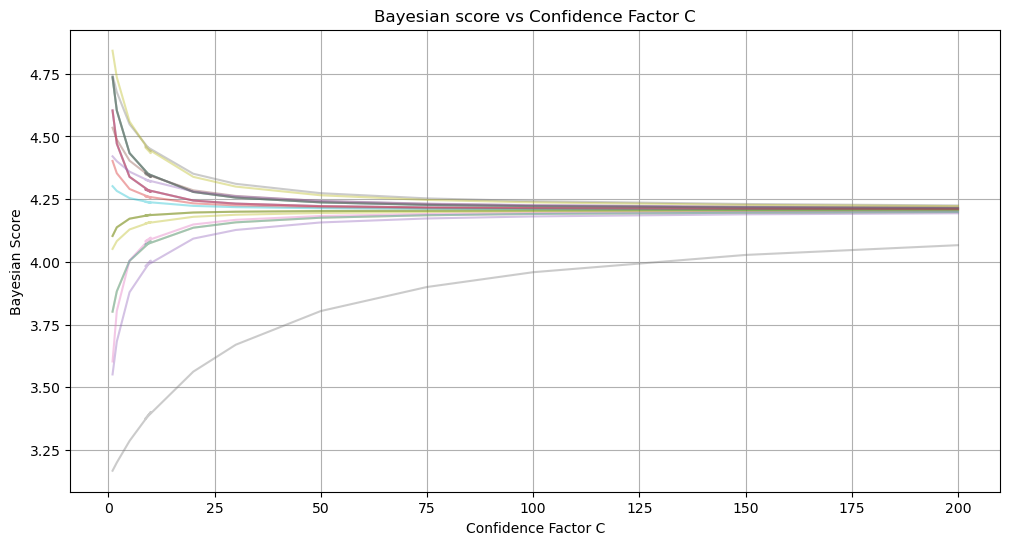

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

sample_titles = scores_pivot['title'].sample(20)

for title in sample_titles:
    row = scores_pivot[scores_pivot['title'] == title].iloc[0]
    y = [row[f"C_{C}"] for C in C_values]
    plt.plot(C_values, y, alpha=0.4)

plt.title("Bayesian score vs Confidence Factor C")
plt.xlabel("Confidence Factor C")
plt.ylabel("Bayesian Score")
plt.grid(True)
plt.show()


In [33]:
topk_changes = []

for C in C_values:
    top20 = bayesian_scoring(review_df, C, m).head(15)['title'].tolist()
    topk_changes.append(top20)

pd.DataFrame(topk_changes, index=C_values)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
1.000000,Lilla Belle: The First Stages,There Are Survivors: The Michael Cuccione Story,The Road to Guadalupe: A Modern Pilgrimage to ...,Angel Unaware: A Touching Story of Love and Loss,The ice people,The Hebrew Kid and the Apache Maiden,The Joyous Season,A Reason To Live : The True Story of One Woman...,The Four Laws of Debt Free Prosperity,Maximized Manhood,I Could've Written a Better Movie Than That! :...,Mending the Soul: Understanding and Healing Abuse,Sandbox Wisdom: Revolutionize Your Brand with ...,The Human Fabric: Unleashing the Power of Core...,Shibori: The Inventive Art of Japanese Shaped ...
2.000000,Lilla Belle: The First Stages,There Are Survivors: The Michael Cuccione Story,The Road to Guadalupe: A Modern Pilgrimage to ...,Angel Unaware: A Touching Story of Love and Loss,the lion's paw,The ice people,The Hebrew Kid and the Apache Maiden,The Joyous Season,The Four Laws of Debt Free Prosperity,A Reason To Live : The True Story of One Woman...,The Wealthy Spirit: Daily Affirmations for Fin...,Mending the Soul: Understanding and Healing Abuse,Maximized Manhood,I Could've Written a Better Movie Than That! :...,Sandbox Wisdom: Revolutionize Your Brand with ...
5.000000,Lilla Belle: The First Stages,the lion's paw,There Are Survivors: The Michael Cuccione Story,The Wealthy Spirit: Daily Affirmations for Fin...,"The Ferret Calendar 2005, Ferret Music",The Road to Guadalupe: A Modern Pilgrimage to ...,Golf in Scotland: A Travel-Planning Guide with...,Dancing the Dream: Poems and Reflections,"Why revival tarries,",Angel Unaware: A Touching Story of Love and Loss,With the Old Breed: At Peleliu and Okinawa,The Valley of Vision: a Collection of Puritan ...,shadow castle,Up Front,The Hebrew Kid and the Apache Maiden
10.000000,Lilla Belle: The First Stages,With the Old Breed: At Peleliu and Okinawa,"The Ferret Calendar 2005, Ferret Music",the lion's paw,The Wealthy Spirit: Daily Affirmations for Fin...,The Valley of Vision: a Collection of Puritan ...,Betty Crocker's cooky book,There Are Survivors: The Michael Cuccione Story,Dancing the Dream: Poems and Reflections,Golf in Scotland: A Travel-Planning Guide with...,CARS AND TRUCKS AND THINGS THAT GO,"Why revival tarries,",shadow castle,Azucar! The Story of Sugar,My Brother's Voice: How a Young Hungarian Boy ...
8.718975,Lilla Belle: The First Stages,the lion's paw,"The Ferret Calendar 2005, Ferret Music",With the Old Breed: At Peleliu and Okinawa,The Wealthy Spirit: Daily Affirmations for Fin...,The Valley of Vision: a Collection of Puritan ...,There Are Survivors: The Michael Cuccione Story,Golf in Scotland: A Travel-Planning Guide with...,Dancing the Dream: Poems and Reflections,Betty Crocker's cooky book,"Why revival tarries,",shadow castle,The Road to Guadalupe: A Modern Pilgrimage to ...,CARS AND TRUCKS AND THINGS THAT GO,Azucar! The Story of Sugar
20.000000,With the Old Breed: At Peleliu and Okinawa,Lilla Belle: The First Stages,"The Ferret Calendar 2005, Ferret Music",The Valley of Vision: a Collection of Puritan ...,Betty Crocker's cooky book,CARS AND TRUCKS AND THINGS THAT GO,The Wealthy Spirit: Daily Affirmations for Fin...,the lion's paw,Tear Soup: A Recipe for Healing After Loss,Where the Sidewalk Ends: Poems and Drawings,Harrington on Hold 'em Expert Strategy for No ...,Left to Tell: Discovering God Amidst The Rwand...,My Brother's Voice: How a Young Hungarian Boy ...,The Lost Years: Surviving a Mother and Daughte...,The Gruffalo (Picture Books)
30.000000,With the Old Breed: At Peleliu and Okinawa,"The Ferret Calendar 2005, Ferret Music",Lilla Belle: The First Stages,Betty Crocker's cooky book,The Valley of Vision: a Collection of Puritan ...,CARS AND TRUCKS AND THINGS THAT GO,Tear Soup: A Recipe for Healing After Loss,Where the Sidewalk Ends: Poems and Drawings,Left to Tell: Discovering God Amidst The Rwand...,Harrington on Hold 'em Expert Strategy for No ...,The monster at the end of this book (A little ...,Taking Charge of Yo

c:\Users\insiy\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


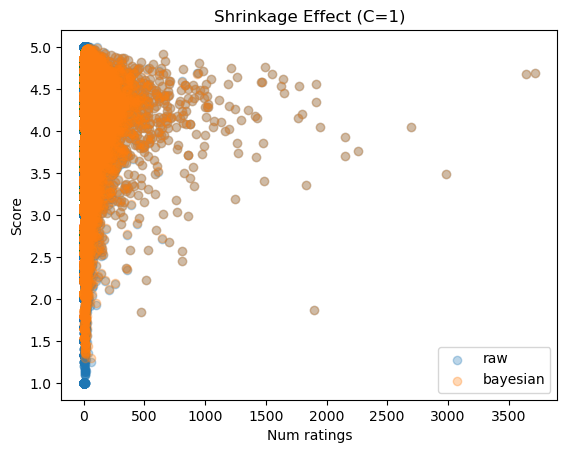

c:\Users\insiy\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


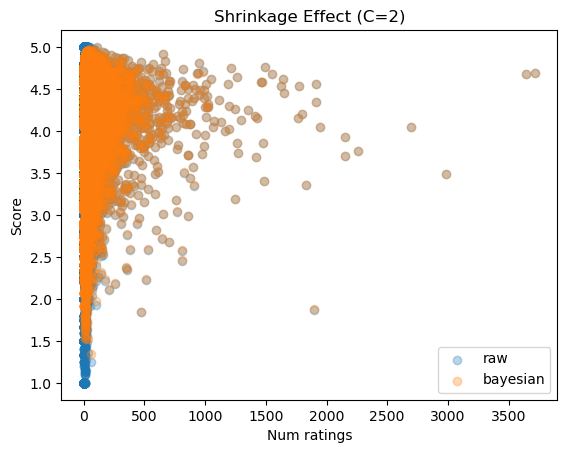

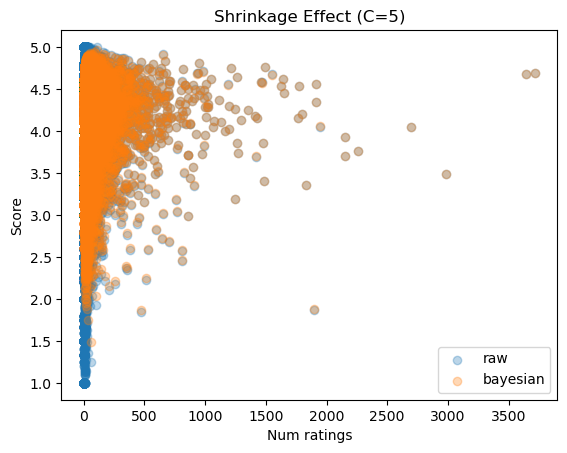

c:\Users\insiy\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


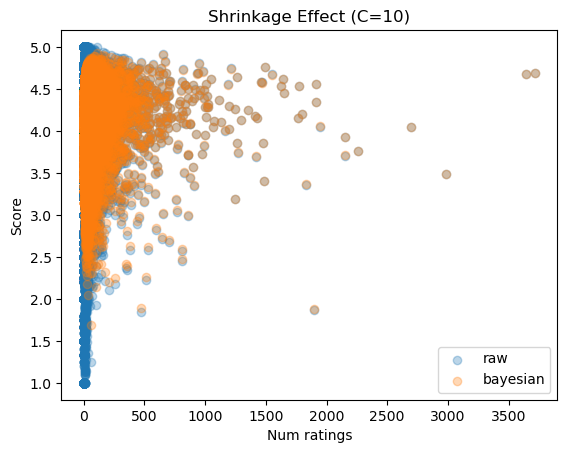

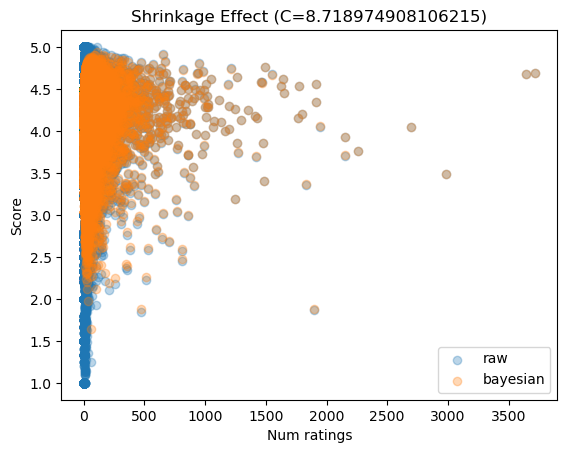

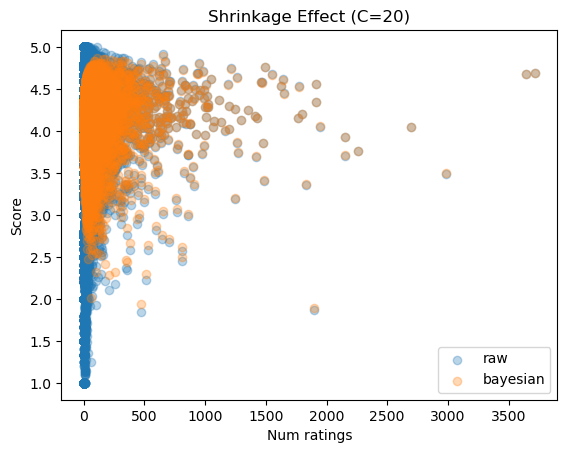

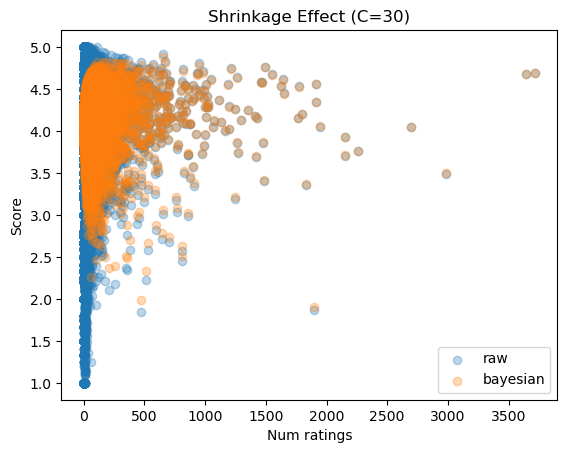

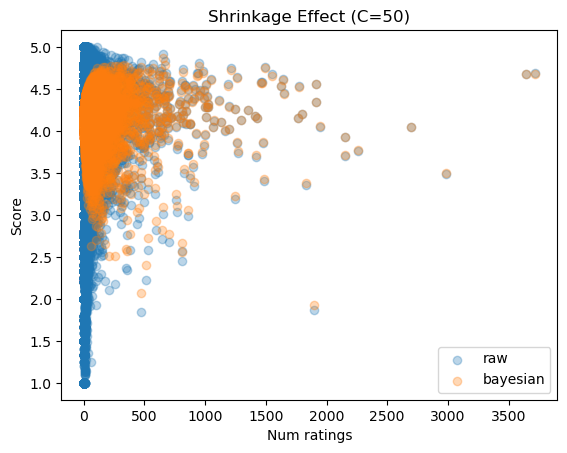

c:\Users\insiy\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


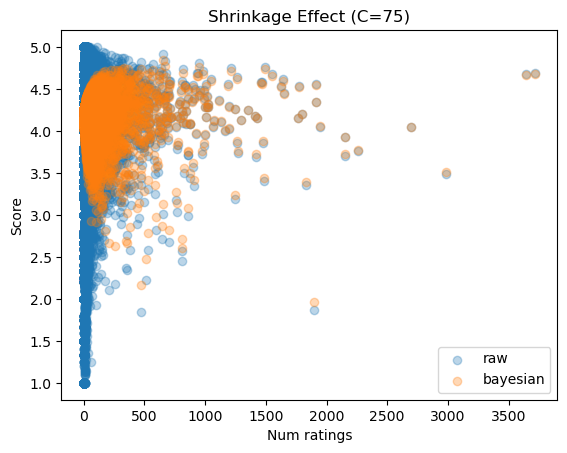

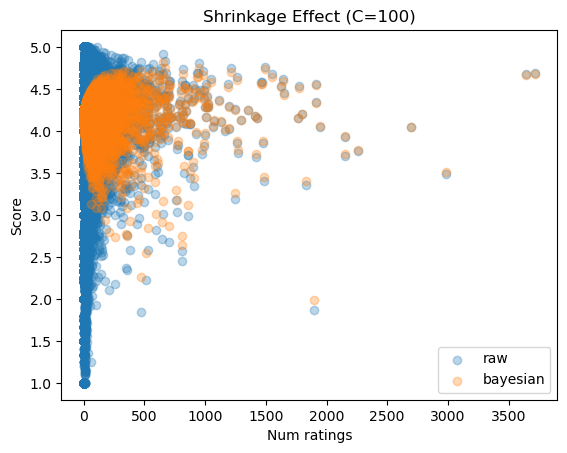

c:\Users\insiy\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


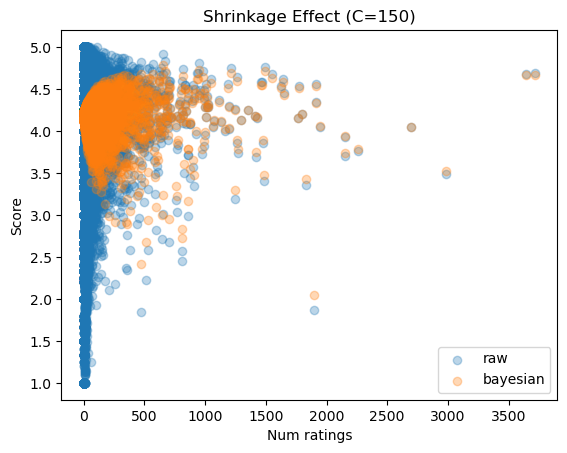

c:\Users\insiy\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


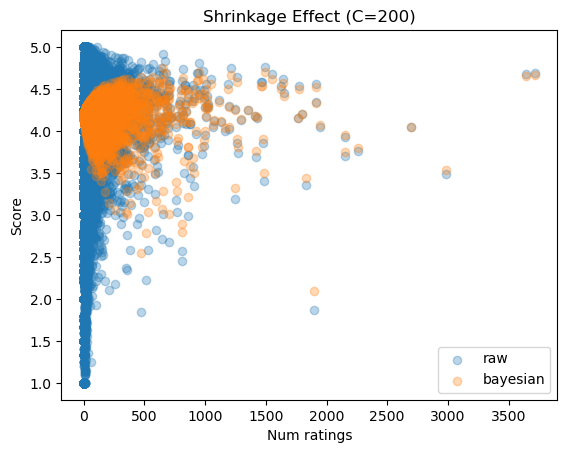

In [34]:
books = review_df.groupby('title').agg(
    avg_rating=('score', 'mean'),
    num_ratings=('score', 'count')
).reset_index()


for C in C_values:
    books['bayes'] = (C*m + books['num_ratings']*books['avg_rating']) / (C + books['num_ratings'])

    plt.scatter(books['num_ratings'], books['avg_rating'], alpha=0.3, label='raw')
    plt.scatter(books['num_ratings'], books['bayes'], alpha=0.3, label='bayesian')
    plt.xlabel("Num ratings")
    plt.ylabel("Score")
    plt.title(f"Shrinkage Effect (C={C})")
    plt.legend()
    plt.show()




# Ignore

In [102]:


# Step 1: Convert string representations of lists to actual lists
def ensure_list(x):
    if isinstance(x, str):
        return ast.literal_eval(x)
    return x

df = book_genre.copy()
df['categories'] = df['categories'].apply(ensure_list)

# Step 2: Clean up category strings
df['categories'] = df['categories'].apply(lambda lst: [cat.strip() for cat in lst])

# Step 3: Keep only meaningful categories (optional but helps)
# Example: keep categories that appear more than N times
N = 1000


from collections import Counter
all_categories = [cat for sublist in df['categories'] for cat in sublist]
cat_counts = Counter(all_categories)
top_categories = {cat for cat, count in cat_counts.items() if count > N}  # only categories with >5 books

df['categories'] = df['categories'].apply(lambda lst: [cat for cat in lst if cat in top_categories])

# Step 4: One-hot encode using MultiLabelBinarizer
mlb = MultiLabelBinarizer()
df_onehot = df.join(pd.DataFrame(mlb.fit_transform(df['categories']),
                                 columns=mlb.classes_,
                                 index=df.index))

print(df_onehot.head())

                                               title  \
0                     Its Only Art If Its Well Hung!   
1                           Dr. Seuss: American Icon   
2              Wonderful Worship in Smaller Churches   
3                      Whispers of the Wicked Saints   
5  The Church of Christ: A Biblical Ecclesiology ...   

                    categories  art  biography & autobiography  \
0    [comics & graphic novels]    0                          0   
1  [biography & autobiography]    0                          1   
2                   [religion]    0                          0   
3                    [fiction]    0                          0   
5                   [religion]    0                          0   

   body, mind & spirit  business & economics  comics & graphic novels  \
0                    0                     0                        1   
1                    0                     0                        0   
2                    0                     0   

### Data Analysis

In [ ]:
num_columns = df_onehot.shape[1]
print(f'Number of columns in book-genre dataframe: {num_columns}')
genre_columns = [col for col in df_onehot.columns if (col != 'title' and col!='categories')]
print(f'Number of genres that appear in more than {N} books: {len(genre_columns)}')
print(f'Genres: {genre_columns}')




Number of columns in book-genre dataframe: 37
Number of genres that appear in more than 1000 books: 35
Genres: ['art', 'biography & autobiography', 'body, mind & spirit', 'business & economics', 'comics & graphic novels', 'computers', 'cooking', 'crafts & hobbies', 'education', 'family & relationships', 'fiction', 'foreign language study', 'health & fitness', 'history', 'juvenile fiction', 'juvenile nonfiction', 'language arts & disciplines', 'literary criticism', 'mathematics', 'medical', 'music', 'nature', 'performing arts', 'philosophy', 'poetry', 'political science', 'psychology', 'reference', 'religion', 'science', 'self-help', 'social science', 'sports & recreation', 'technology & engineering', 'travel']


In [104]:
# data analysis --- not relevant for problem
genres = []
counts = []

for genre in genre_columns:
    num_books = df_onehot[genre].sum()  # sum of 0/1 column = number of books
    genres.append(genre)
    counts.append(num_books)

df_genre_counts = pd.DataFrame({
    'genre': genres,
    'count': counts
})

# Sort descending
df_genre_counts = df_genre_counts.sort_values(by='count', ascending=False).reset_index(drop=True)

print(df_genre_counts.head(20))

                          genre  count
0                       fiction  23470
1                      religion   9471
2                       history   9347
3              juvenile fiction   6671
4     biography & autobiography   6341
5          business & economics   5629
6                     computers   4317
7                social science   3839
8           juvenile nonfiction   3464
9                       science   2629
10                    education   2615
11                      cooking   2452
12          sports & recreation   2268
13       family & relationships   2204
14           literary criticism   2149
15                        music   2109
16                      medical   2087
17                          art   2061
18          body, mind & spirit   2049
19  language arts & disciplines   2040


In [110]:
# Check if any of the top 100 genres = 1
genre_columns = [col for col in df_onehot.columns if col != 'title' and col!='categories']
print(f'Genre count: {len(genre_columns)}')

# Count how many books have each genre
genre_counts = df_onehot[genre_columns].sum().sort_values(ascending=False)



print(df_onehot.shape)

#removing books that do not have the top genres -> not relevant books
df_top = df_onehot[df_onehot[genre_columns].sum(axis=1) > 0]

print(df_top.shape)  # new shape after removing books with no top 100 genres

df_top['num_genres'] = df_top[genre_columns].sum(axis=1)
df_top['num_genres'].sum()

Genre count: 35
(171205, 37)
(120382, 37)


C:\Users\insiy\AppData\Local\Temp\ipykernel_16136\2697103713.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top['num_genres'] = df_top[genre_columns].sum(axis=1)


120382

### Jaccard Similarity

In [96]:
df_top.head()
genres_only = df_top[genre_columns]
genres_only

,art,biography & autobiography,"body, mind & spirit",business & economics,comics & graphic novels,computers,cooking,crafts & hobbies,education,family & relationships,...,political science,psychology,reference,religion,science,self-help,social science,sports & recreation,technology & engineering,travel
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212397,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
212398,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
212399,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
212400,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [97]:
from sklearn.metrics import pairwise_distances
from scipy.sparse import csr_matrix

# convert to sparse matrix
genres_sparse = csr_matrix(genres_only.values)

# compute Jaccard distances
consine_distance = pairwise_distances(genres_sparse, metric='cosine')


MemoryError: Unable to allocate 3.66 GiB for an array with shape (982643074,) and data type int32

In [60]:

def recommend_books_by_genre(book_title, book_df, genre_columns, top_n=10):
    """
    Recommend books based on genre similarity using one-hot encoded genres.

    book_title: title of the book to find similar books for
    book_df: dataframe with columns [title] + genre_columns (one-hot)
    genre_columns: list of genre columns
    top_n: number of books to recommend
    """
    # Get book index
    if book_title not in book_df['title'].values:
        raise ValueError(f"Book '{book_title}' not found in dataframe.")

    book_idx = book_df.index[book_df['title'] == book_title][0]

    # Extract one-hot genre vectors
    book_vector = book_df.loc[book_idx, genre_columns].values.reshape(1, -1)
    all_vectors = book_df[genre_columns].values

    # Compute cosine similarity
    similarities = cosine_similarity(book_vector, all_vectors).flatten()

    # Get top N similar books (excluding the book itself)
    similar_idx = similarities.argsort()[::-1]  # descending
    similar_idx = similar_idx[similar_idx != book_idx]  # remove itself

    top_books = book_df.iloc[similar_idx[:top_n]].copy()
    top_books['similarity_score'] = similarities[similar_idx[:top_n]]

    return top_books[['title', 'similarity_score']]


In [64]:


recommendations = recommend_books_by_genre(
    book_title="Dr. Seuss: American Icon",
    book_df=book_genre,
    genre_columns=genre_columns,
    top_n=10
)

print(recommendations)

KeyError: "None of [Index(['american literature', 'antiques & collectibles', 'architecture', 'art',\n       'bible', 'bibles', 'biography & autobiography', 'body, mind & spirit',\n       'business & economics', 'children's stories', 'comics & graphic novels',\n       'computers', 'cooking', 'crafts & hobbies', 'design', 'drama',\n       'education', 'english language', 'family & relationships', 'fiction',\n       'foreign language study', 'games', 'games & activities', 'gardening',\n       'great britain', 'health & fitness', 'history', 'house & home', 'humor',\n       'juvenile fiction', 'juvenile nonfiction',\n       'language arts & disciplines', 'law', 'literary collections',\n       'literary criticism', 'mathematics', 'medical', 'music', 'nature',\n       'performing arts', 'pets', 'philosophy', 'photography', 'poetry',\n       'political science', 'psychology', 'reference', 'religion', 'science',\n       'self-help', 'social science', 'sports & recreation', 'study aids',\n       'technology & engineering', 'transportation', 'travel', 'true crime',\n       'united states', 'young adult fiction'],\n      dtype='object')] are in the [index]"

In [13]:
# Convert one-hot encoded genres to a space-separated string
genre_columns = df_top.columns[2:]  # assuming first two columns are title and categories
print(df_top.columns.tolist())

df_top['genre_text'] = df_top[genre_columns].apply(lambda x: ' '.join([col for col in genre_columns if x[col]==1]), axis=1)

['title', 'categories', 'American literature', 'Antiques & Collectibles', 'Architecture', 'Art', 'Bible', 'Bibles', 'Biography & Autobiography', 'Body, Mind & Spirit', 'Business & Economics', "Children's stories", 'Comics & Graphic Novels', 'Computers', 'Cooking', 'Crafts & Hobbies', 'Design', 'Drama', 'Education', 'English language', 'Family & Relationships', 'Fiction', 'Foreign Language Study', 'Games', 'Games & Activities', 'Gardening', 'Great Britain', 'Health & Fitness', 'History', 'House & Home', 'Humor', 'Juvenile Fiction', 'Juvenile Nonfiction', 'Language Arts & Disciplines', 'Law', 'Literary Collections', 'Literary Criticism', 'Mathematics', 'Medical', 'Music', 'Nature', 'Performing Arts', 'Pets', 'Philosophy', 'Photography', 'Poetry', 'Political Science', 'Psychology', 'Reference', 'Religion', 'Science', 'Self-Help', 'Social Science', 'Sports & Recreation', 'Study Aids', 'Technology & Engineering', 'Transportation', 'Travel', 'True Crime', 'United States', 'Young Adult Fictio

C:\Users\insiy\AppData\Local\Temp\ipykernel_20200\3489103508.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top['genre_text'] = df_top[genre_columns].apply(lambda x: ' '.join([col for col in genre_columns if x[col]==1]), axis=1)


## Pause

In [14]:
df_top.head()

,title,categories,American literature,Antiques & Collectibles,Architecture,Art,Bible,Bibles,Biography & Autobiography,"Body, Mind & Spirit",...,Social Science,Sports & Recreation,Study Aids,Technology & Engineering,Transportation,Travel,True Crime,United States,Young Adult Fiction,genre_text
0,Its Only Art If Its Well Hung!,[Comics & Graphic Novels],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Comics & Graphic Novels
1,Dr. Seuss: American Icon,[Biography & Autobiography],0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Biography & Autobiography
2,Wonderful Worship in Smaller Churches,[Religion],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Religion
3,Whispers of the Wicked Saints,[Fiction],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fiction
5,The Church of Christ: A Biblical Ecclesiology ...,[Religion],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Religion


In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

custom_list_stop_words = list(ENGLISH_STOP_WORDS.union({'00', '000', '00am', '00pm', '10', '100', '1000', '101', '10pm', '10th', '11'
 '11th', '12', '129', '12th', '13', '13th', '14','147','15', '150', '15th', '16'
 '16th', '17', '&'}))

vectorizer = TfidfVectorizer(min_df=2, max_df=0.7, stop_words=custom_list_stop_words)
vectorized_data = vectorizer.fit_transform(df_top['genre_text'])
df_top['genre_text']



0           Comics & Graphic Novels
1         Biography & Autobiography
2                          Religion
3                           Fiction
5                          Religion
                    ...            
212397          Body, Mind & Spirit
212398                    Computers
212399             Juvenile Fiction
212400             Juvenile Fiction
212402                      Fiction
Name: genre_text, Length: 133861, dtype: object

In [32]:
features = len(vectorizer.get_feature_names_out())
features





83

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

custom_list_stop_words = list(ENGLISH_STOP_WORDS.union({'00', '000', '00am', '00pm', '10', '100', '1000', '101', '10pm', '10th', '11'
 '11th', '12', '129', '12th', '13', '13th', '14','147','15', '150', '15th', '16'
 '16th', '17', '&'}))

vectorizer = TfidfVectorizer(min_df=2, max_df=0.7, stop_words=custom_list_stop_words)
vectorized_data = vectorizer.fit_transform(df_top['genre_text'])
df_top['genre_text']

features = len(vectorizer.get_feature_names_out())
features

tfidf_df = pd.DataFrame(
    vectorized_data.toarray(),
    columns=vectorizer.get_feature_names_out()
)

tfidf_df.head()

In [35]:
tfidf_df.head()


,activities,adult,aids,american,antiques,architecture,art,arts,autobiography,bible,...,sports,states,stories,study,technology,transportation,travel,true,united,young
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.707107,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
# Example: user selects Fiction, Science, Travel
user_genres = ['Fiction']
user_profile = ' '.join(user_genres)

# Convert user profile to TF-IDF vector
user_vec = tfidf.transform([user_profile])


In [88]:
from sklearn.metrics.pairwise import cosine_similarity

# similarity between user and all books
similarities = cosine_similarity(user_vec, tfidf_matrix)

# flatten and get top N recommendations
similarities = similarities.flatten()
len(similarities)
top_n = 100
top_indices = similarities.argsort()[-top_n:][::-1]


recommended_books = df_top.iloc[top_indices][['title', 'categories']]
print(recommended_books)



                                                    title categories
184876                 Java J2SE 1.4 Core Platform Update  [Science]
19037   The philosophy of no;: A philosophy of the new...  [Science]
203048          Fundamentals of Electronic Circuit Design  [Science]
97532   Quantum Cybernetics: Toward a Unification of R...  [Science]
56279   Exploding the Gene Myth: How Genetic Informati...  [Science]
56276        Longest Walk: An Odyssey of the Human Spirit  [Science]
97540   Biogeochemistry of Marine Dissolved Organic Ma...  [Science]
138673                      The Gentle Art Of Mathematics  [Science]
138669  Heat Kernel and Quantum Gravity (Lecture Notes...  [Science]
18955                         Age of Anxiety 2ND Printing  [Science]
138653   Nte Biology & General Science: Practice & Review  [Science]
138651        The Essential Atlas of Fossils and Minerals  [Science]
56193   Weather and life: An introduction to biometeor...  [Science]
138615                         Que

## Restart

In [38]:
genre_columns = df_top.columns[2:]

# create a space-separated string of genres for each book

df_top['genre_text'] = df_top[genre_columns].apply(
    lambda x: ' '.join([col for col in genre_columns if x[col]==1]), axis=1
)


C:\Users\insiy\AppData\Local\Temp\ipykernel_20200\2659300228.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top['genre_text'] = df_top[genre_columns].apply(


In [41]:
# Custom stop words (you can adjust for your dataset)
custom_list_stop_words = list(ENGLISH_STOP_WORDS.union({
    '00', '000', '00am', '00pm', '10', '100', '1000', '101', '10pm', '10th', 
    '11', '11th', '12', '129', '12th', '13', '13th', '14','147','15', 
    '150', '15th', '16', '16th', '17', '&'
}))

vectorizer = TfidfVectorizer(min_df=2, max_df=0.7, stop_words=custom_list_stop_words)

# Fit TF-IDF to your genre_text
vectorized_data = vectorizer.fit_transform(df_top['genre_text'])

# Convert to dataframe if you want to inspect
tfidf_df = pd.DataFrame(vectorized_data.toarray(), columns=vectorizer.get_feature_names_out())


In [ ]:
tfidf_df.head()

cosine_similarity_array = cosine_similarity(tfidf_df)
print(cosine_similarity_array[0:10, 0:5])

,activities,adult,aids,american,antiques,architecture,art,arts,autobiography,bible,...,sports,states,stories,study,technology,transportation,travel,true,united,young
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.707107,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# Suppose the new user selects genres
user_genres = ['Fiction', 'Science', 'Travel']
user_profile = ' '.join(user_genres)

# Convert user profile into TF-IDF vector (same vectorizer)
user_vec = vectorizer.transform([user_profile])

# Compute cosine similarity
similarities = cosine_similarity(user_vec, vectorized_data).flatten()

# Get top N recommendations
top_n = 10
top_indices = similarities.argsort()[-top_n:][::-1]

recommended_books = df_top.iloc[top_indices][['title', 'categories']]
print(recommended_books)


                                                    title categories
47262   Rand McNally Central United States: Highways &...   [Travel]
179708                  Eyewitness Travel Planner: France   [Travel]
89895                          Let's Go 2003: New Zealand   [Travel]
89901     Moon Handbooks Northern California Wine Country   [Travel]
35070   Buying a Property: Florida (Buying a Property ...   [Travel]
107727                                    Russian Journal   [Travel]
107710  NORTH CAROLINA WATERFALLS: WHERE TO FIND THEM,...   [Travel]
205269                 Trieste and the Meaning of Nowhere   [Travel]
168128  Tartans, Over 300 historic and modern tartans ...   [Travel]
107695                  Frommer's 99 New Orleans (Serial)   [Travel]


In [53]:
similarities.argsort()[-20:]

array([132660, 132659, 132658, 132657, 132656, 132655, 132654, 132653,
       132652, 132651, 132650, 132649, 132648, 132647, 132646, 132645,
       132644, 132643, 132669, 133860], dtype=int64)

In [ ]:
# custom_list_stop_words = list(ENGLISH_STOP_WORDS.union({'&','book', 'novel', 'genre', 'story','[',']',}))

# vectorizer = TfidfVectorizer(
#     min_df=250,
#     max_df=0.7,
#     stop_words=custom_list_stop_words,  
#     token_pattern=r"(?u)\b[a-zA-Z]+\b"
# )

# tfidf_matrix = vectorizer.fit_transform(book_genre['categories_clean'])
# print(len(vectorizer.get_feature_names_out()))
# print(vectorizer.get_feature_names_out())

# tfidf_df = pd.DataFrame(
#     vectorized_data.toarray(), 
#     columns=vectorizer.get_feature_names_out()
# )


98
['activities' 'adult' 'african' 'aids' 'american' 'americans' 'animals'
 'antiques' 'architecture' 'art' 'arts' 'authors' 'autobiography' 'bible'
 'bibles' 'biography' 'body' 'books' 'britain' 'business' 'character'
 'children' 'christian' 'collectibles' 'collections' 'comics' 'computer'
 'computers' 'cooking' 'crafts' 'crime' 'criticism' 'design' 'detective'
 'disciplines' 'drama' 'economics' 'education' 'engineering' 'english'
 'family' 'fiction' 'fictitious' 'fitness' 'foreign' 'games' 'gardening'
 'graphic' 'great' 'health' 'help' 'history' 'hobbies' 'home' 'house'
 'humor' 'juvenile' 'language' 'law' 'life' 'literary' 'literature'
 'mathematics' 'medical' 'mind' 'music' 'mystery' 'nature' 'nonfiction'
 'novels' 'performing' 'pets' 'philosophy' 'photography' 'poetry'
 'political' 'psychology' 'recreation' 'reference' 'relationships'
 'religion' 's' 'science' 'self' 'social' 'spirit' 'sports' 'states'
 'stories' 'study' 'technology' 'transportation' 'travel' 'true' 'united'
 'war